<a href="https://colab.research.google.com/github/bryandaetz1/Apartment_Rent_Prices/blob/master/Apartments_EDA_%26_Model_Building_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#for histogram and normal probability plot
from scipy.stats import norm   
from scipy import stats

In [108]:
df = pd.read_csv('https://raw.githubusercontent.com/bryandaetz1/Apartment_Rent_Prices/master/apartment_data_clean.csv')

# Initial Exploratory Data Analysis

In [109]:
df.describe()

,Bedrooms,Bathrooms,Zip_Code,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
count,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.00000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000
mean,1.454400,1.422202,94606.432093,3535.366650,920.733793,0.042149,0.453907,0.583559,0.673774,0.532783,0.907937,0.560143,0.335839,0.572098,0.191891,0.129283,0.078999,0.248459,0.683140,0.431107,0.479049,0.10944,0.518856,0.690535,0.342987,0.206433,0.120039,0.205817,0.280503,0.425068,0.104018,0.124723
std,0.899322,0.562440,429.814280,1401.388031,1624.074355,0.200942,0.497902,0.492999,0.468860,0.498955,0.289133,0.496400,0.472312,0.494805,0.393812,0.335533,0.269754,0.432146,0.465281,0.495261,0.499592,0.31221,0.499675,0.462302,0.474737,0.404770,0.325028,0.404322,0.449273,0.494384,0.305302,0.330425
min,0.000000,0.500000,94014.000000,830.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,94109.000000,2665.000000,650.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,94612.000000,3272.000000,825.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,95110.000000,4075.000000,1071.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,6.000000,5.500000,95148.000000,30000.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Immediately it becomes evident that there are outliers in the dataset.  For instance the max rent is $30,000 and the max square footage is 99,999.  In both cases this is well about the 75th percentile.  

Additionally, it looks like a few of the binary features I extracted from the amenities text have an extremely low or extremely high mean, indicating that the values for these features are predominantly uniform.  For example, Bosch Appliances has a mean of 0.042, Pets Allowed: 0.109, Plank Floor: 0.104, Tile Floor: 0.124, and Laundry: 0.907. These features may not end up being useful to include in the model.  

## Addressing Outliers in Avg_Rent Column

In [110]:
#descriptive statistics for rent grouped by bedroom size
rent_averages = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].mean())
percentile_10 = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].quantile(.10))
percentile_90 = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].quantile(.90))
rent_min = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].min())
rent_max = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].max())
std = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].std())
count = df.groupby('Bedrooms', as_index = False).size()

rent_df = pd.DataFrame({'Bedrooms':rent_averages['Bedrooms'],
                        'Average_Rent':rent_averages['Avg_Rent'],
                        '10th_Percentile':percentile_10['Avg_Rent'], 
                        '90th_Percentile':percentile_90['Avg_Rent'],
                        'Minimum':rent_min['Avg_Rent'],
                        'Maximum':rent_max['Avg_Rent'],
                        'Standard_Deviation':std['Avg_Rent'],
                        'Count':count,
                        '% of Dataset':(count/len(df) * 100)})
rent_df

,Bedrooms,Average_Rent,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,2648.0,1881.0,3335.0,1004,7950,645.0,1065,13.125462
1,1,3076.0,2187.0,4151.0,830,23000,877.0,3265,40.239093
2,2,3993.0,2660.0,5610.0,950,13000,1241.0,3020,37.219620
3,3,4731.0,3095.0,6614.0,1166,20000,1866.0,593,7.308356
4,4,5511.0,3496.0,6540.0,1154,30000,3921.0,143,1.762386
5,5,6308.0,2003.0,11800.0,999,14500,3566.0,23,0.283461
6,6,5041.0,979.0,8300.0,979,9000,3787.0,5,0.061622


The 5 and 6 bedroom listings combined make up less than 0.35% of the dataset and have a high standard deviation, so I elected to remove these listings.

In [111]:
#dropping 5 and 6 bedroom listings
df.drop(df[df['Bedrooms'] > 4].index, axis = 0, inplace = True)

## Addressing Outliers in Avg_Sqft Column

In [112]:
#descriptive statistics for square footage grouped by bedroom size
sqft_averages = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].mean())
sqft_10 = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].quantile(.10))
sqft_90 = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].quantile(.90))
sqft_min = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].min())
sqft_max = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].max())
sqft_std = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].std())
count = df.groupby('Bedrooms', as_index = False).size()

sqft_df = pd.DataFrame({'Bedrooms':sqft_averages['Bedrooms'],
                        'Average_Sqft':sqft_averages['Avg_Sqft'],
                        '10th_Percentile':sqft_10['Avg_Sqft'], 
                        '90th_Percentile':sqft_90['Avg_Sqft'],
                        'Minimum':sqft_min['Avg_Sqft'],
                        'Maximum':sqft_max['Avg_Sqft'],
                        'Standard_Deviation':sqft_std['Avg_Sqft'],
                        'Count':count,
                        '% of Dataset':(count/len(df) * 100)})
sqft_df

,Bedrooms,Average_Sqft,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,496.0,380.0,608.0,1.0,3181.0,148.0,1065,13.170913
1,1,718.0,540.0,879.0,1.0,7698.0,264.0,3265,40.378432
2,2,1114.0,836.0,1254.0,1.0,99999.0,2555.0,3020,37.348504
3,3,1518.0,1095.0,1846.0,1.0,8695.0,922.0,593,7.333663
4,4,1899.0,1290.0,2741.0,1.0,5113.0,726.0,143,1.768489


Clearly there are some outliers in the square footage column that I'll need to address.  These minimum and maximum values of 1.0 and 99999.0 obviously do not represent actual square footages, so I'm going to further examine them and then replace these incorrect values with the average square footage for the respective bedroom size.

In [113]:
df[df['Avg_Sqft'] < 100]

,Bedrooms,Bathrooms,City,Zip_Code,Neighborhood,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
1671,1,1.0,Oakland,94609,Hoover-Foster,1725,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1717,1,1.0,Oakland,94610,Westlake,2450,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1761,1,1.0,Alameda,94501,Downtown Alameda,1900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1771,0,1.0,Berkeley,94704,South Berkeley,1600,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1812,1,1.0,Alameda,94501,West Alameda,1890,1.0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4570,3,1.0,San Francisco,94107,SoMa,2900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4571,3,1.0,San Francisco,94107,SoMa,2900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4654,1,1.0,San Francisco,94118,Richmond District,1800,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4669,2,1.0,San Francisco,94110,Mission,4850,1.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4701,0,1.0,San Francisco,94103,SoMa,1100,80.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


Considering the size of apartments in San Francisco, the 80 sqft studio apartment in San Francisco could potentially be a real value, but the other listings with a square footage of 1.0 or 5.0 clearly are not.  I'm going to replace all square footage values of less than 50 with the average sqft value for the respective bedroom size.

In [114]:
# replacing instances where square footage was incorrectly listed as less than 50 with the average square footage for that bedroom size
for i in range (0,5):
  df.loc[(df['Avg_Sqft'] < 50) & (df['Bedrooms'] == i),'Avg_Sqft'] = sqft_df['Average_Sqft'][i]

In [115]:
df[df['Avg_Sqft'] > 9000]

,Bedrooms,Bathrooms,City,Zip_Code,Neighborhood,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
4920,2,1.0,San Francisco,94118,Lone Mountain,3200,99999.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4921,2,1.0,San Francisco,94134,Visitacion Valley,2950,99999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [116]:
#since the only listings with a sqft > 9000 are 2 bedroom apts, I'll replace those values with the average sqft for a 2 bedroom
df.loc[df['Avg_Sqft'] > 9000, 'Avg_Sqft'] = sqft_df['Average_Sqft'][2]

## Examining Categorical Variables (City, Zip_Code, and Neighborhood)

In [117]:
df.dtypes

Bedrooms                   int64
Bathrooms                float64
City                      object
Zip_Code                   int64
Neighborhood              object
Avg_Rent                   int64
Avg_Sqft                 float64
Bosch_Appliances           int64
Stainless_Steel_App        int64
Refrigerator               int64
Dishwasher                 int64
Microwave                  int64
Laundry                    int64
Washer/Dryer_in_unit       int64
Terrace                    int64
Balcony                    int64
Vaulted_Ceilings           int64
Garden                     int64
Penthouse                  int64
Concierge                  int64
Lounge                     int64
A/C                        int64
Smoke_Free                 int64
Pets_Allowed               int64
Pool                       int64
Gym                        int64
Gated                      int64
Furnished                  int64
Garage                     int64
Wheelchair_Accessible      int64
Carpet    

In [118]:
pd.DataFrame({'Value Counts':df.City.value_counts(),
              '% of Sample Size':(df.City.value_counts() / len(df)) * 100})

,Value Counts,% of Sample Size
San Francisco,2992,37.002226
San Jose,2256,27.900074
Oakland,1611,19.923324
Milpitas,331,4.093495
Berkeley,205,2.535246
Santa Clara,170,2.102399
Campbell,142,1.756122
Emeryville,113,1.397477
Cupertino,105,1.298541
Alameda,59,0.729656


There are a few cities that appear infrequently (less than 0.5% of the sample size).  One option could be to consolidate them into an "Other" category, but because the goal of this model is to estimate rent prices for people looking for apartments based on the location, an "Other" category likely would not be helpful.

So instead, I'm choosing to drop these instances from the dataset.

In [119]:
df.drop(df.loc[df['City'].isin(['Daly City','San Leandro','Sunnyvale','Los Gatos','Piedmont','Saratoga'])].index, axis = 0, inplace = True)

In [132]:
#getting list of neighborhoods that appear for each city
neighborhood_dict = {'San Francisco': [],
                     'San Jose': [],
                     'Oakland': [],
                     'Milpitas':[],
                     'Berkeley':[],
                     'Santa Clara':[],
                     'Campbell':[],
                     'Emeryville':[],
                     'Cupertino':[],
                     'Alameda':[]}
for city in df['City'].unique():
  neighborhood_dict[city].append(df.loc[df['City'] == city,'Neighborhood'].unique())

In [133]:
neighborhood_dict

{'Alameda': [array(['West Alameda', 'Harbor Bay/Bay Farm', 'Downtown Alameda',
         'South Shore'], dtype=object)],
 'Berkeley': [array(['South Berkeley', 'Downtown Berkeley', 'Berkeley', 'Elmwood',
         'Southside', 'Berkeley Hills', 'Southwest Berkeley',
         'North Berkeley', 'Northeast Oakland Hills'], dtype=object)],
 'Campbell': [array(['San Jose', 'Campbell', 'Downtown Campbell', 'Bonnett',
         'San Tomas', 'Paynes', 'Dry Creek', 'West Campbell', 'Winchester',
         'Joseph'], dtype=object)],
 'Cupertino': [array(['Downtown Cupertino', 'Rancho Rinconada', 'McClellan',
         'Stevens Creek Park'], dtype=object)],
 'Emeryville': [array(['Emeryville', 'Longfellow', 'Golden Gate'], dtype=object)],
 'Milpitas': [array(['Midtown Milpitas', 'Milpitas', 'North Milpitas', 'North San Jose',
         'Berryessa'], dtype=object)],
 'Oakland': [array(['Pill Hill', 'Oakland', 'Piedmont Avenue', 'Westlake', 'Lakeside',
         'Shafter', 'Mosswood', 'Uptown Oakland', 'T

In [141]:
#getting list of zip codes that appear for each city
zip_dict = {'San Francisco': [],
             'San Jose': [],
             'Oakland': [],
             'Milpitas':[],
             'Berkeley':[],
             'Santa Clara':[],
             'Campbell':[],
             'Emeryville':[],
             'Cupertino':[],
             'Alameda':[]}
for city in df['City'].unique():
  zip_dict[city].append(df.loc[df['City'] == city,'Zip_Code'].unique().tolist())

In [142]:
zip_dict

{'Alameda': [[94501, 94502]],
 'Berkeley': [[94704, 94702, 94705, 94708, 94709, 94703, 94710]],
 'Campbell': [[95008]],
 'Cupertino': [[95014]],
 'Emeryville': [[94608]],
 'Milpitas': [[95035]],
 'Oakland': [[94609,
   94606,
   94611,
   94612,
   94619,
   94607,
   94608,
   94601,
   94605,
   94610,
   94621,
   94602,
   94618,
   94603]],
 'San Francisco': [[94102,
   94103,
   94110,
   94107,
   94105,
   94109,
   94112,
   94134,
   94132,
   94158,
   94124,
   94115,
   94111,
   94122,
   94129,
   94108,
   94114,
   94131,
   94121,
   94123,
   94133,
   94116,
   94118,
   94117,
   94127,
   94104]],
 'San Jose': [[95136,
   95110,
   95134,
   95112,
   95133,
   95129,
   95122,
   95113,
   95128,
   95123,
   95126,
   95119,
   95132,
   95125,
   95131,
   95117,
   95124,
   95148,
   95121,
   95118,
   95130,
   95138,
   95127,
   95116,
   95135,
   95120,
   95111,
   95139]],
 'Santa Clara': [[95050, 95054, 95051]]}

After examining the number of unique values per city for both Neighborhood and Zip_Code, it looks like Zip Code is going to be a more useful feature for our model.  Since zip code and neighhorhood convey very similar information, and there are so many different neighborhood values for each city, I would be introducing unneccesary scarcity into the dataset by creating dummy variables for both features.  I think it's going to be more effective here to just use the Zip Code feature.



In [145]:
zip_codes = pd.DataFrame({'Value Counts':df.Zip_Code.value_counts(),
                          '% of Sample Size':(df.Zip_Code.value_counts() / len(df)) * 100})
zip_codes

,Value Counts,% of Sample Size
94612,908,11.372745
94107,593,7.427355
94105,557,6.976453
94103,528,6.613226
95035,331,4.145792
...,...,...
94104,2,0.025050
94127,2,0.025050
94710,1,0.012525
94708,1,0.012525


In [144]:
#getting a list of zip codes that make up less than 1% of sample size
zip_list = zip_codes[zip_codes['% of Sample Size'] < 1].index.tolist()
zip_list

[95125,
 94611,
 95113,
 95119,
 95122,
 94501,
 94122,
 94118,
 95050,
 95117,
 94610,
 94114,
 94124,
 94112,
 94133,
 94108,
 94131,
 94117,
 94702,
 95131,
 94121,
 94123,
 95132,
 95124,
 94134,
 95051,
 95138,
 95130,
 94619,
 95118,
 95121,
 94132,
 94129,
 94601,
 94705,
 94605,
 95127,
 94502,
 94602,
 94116,
 95120,
 95148,
 94703,
 94709,
 95116,
 94618,
 95111,
 94621,
 94603,
 95135,
 94104,
 94127,
 94710,
 94708,
 95139]

In [146]:
zip_dict['Alameda']

[[94501, 94502]]

In [186]:
#creating a new feature where for zip codes that appear in less than 1% of the sample size, the zip code is replaced by 'City - other' where City represents the city
df['Zip_Code_Clean'] = df.apply(lambda x: str(x['City'] + '-other') if x['Zip_Code'] in zip_list else x['Zip_Code'], axis = 1)

In [191]:
#making sure this worked as expected
df[['Zip_Code','Zip_Code_Clean']].head()

,Zip_Code,Zip_Code_Clean
0,94609,94609
1,94609,94609
2,94609,94609
3,94609,94609
4,94609,94609


In [194]:
#making sure this worked as expected
df[['City','Zip_Code','Zip_Code_Clean']].loc[df['Zip_Code_Clean'] != df['Zip_Code']]

,City,Zip_Code,Zip_Code_Clean
148,Oakland,94611,Oakland-other
149,Oakland,94611,Oakland-other
150,Oakland,94611,Oakland-other
151,Oakland,94611,Oakland-other
152,Oakland,94611,Oakland-other
...,...,...,...
8100,San Jose,95118,San Jose-other
8101,San Jose,95125,San Jose-other
8104,San Jose,95135,San Jose-other
8108,San Jose,95117,San Jose-other


## Visualizing the Data

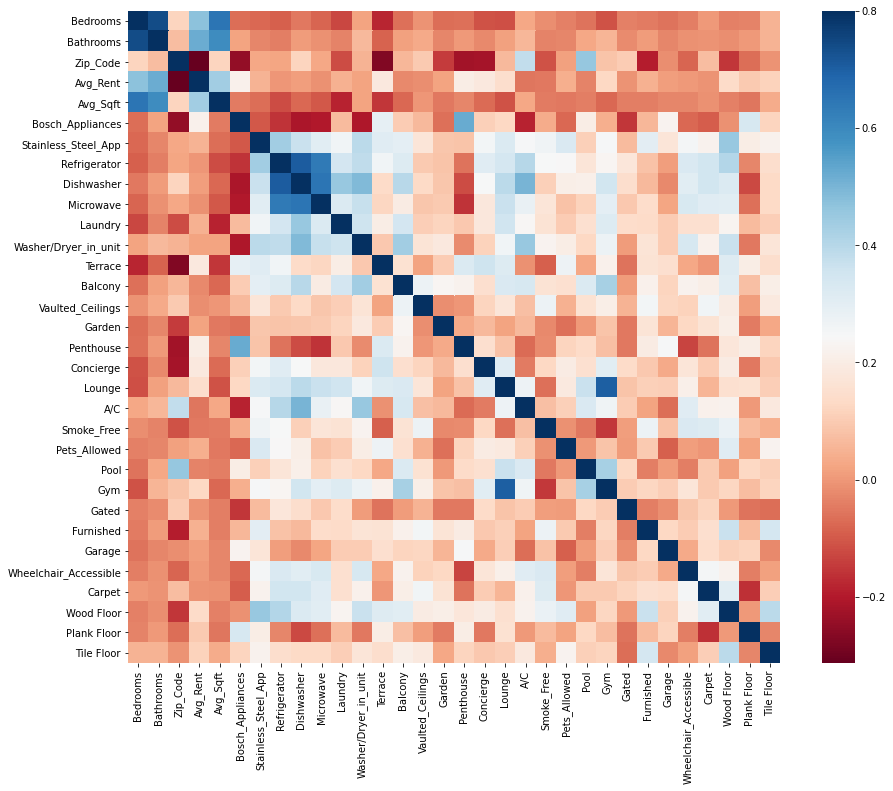

In [195]:
corr_map = df.corr()
f,ax = plt.subplots(figsize = (15,12))
sns.heatmap(corr_map, square = True, vmax = 0.8, cmap = 'RdBu')

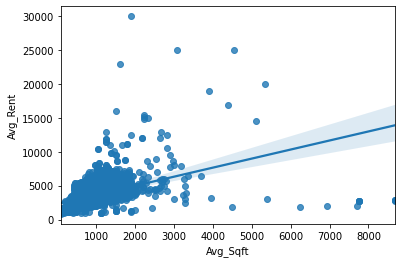

In [197]:
sns.regplot(x = 'Avg_Sqft', y = 'Avg_Rent', data = df)

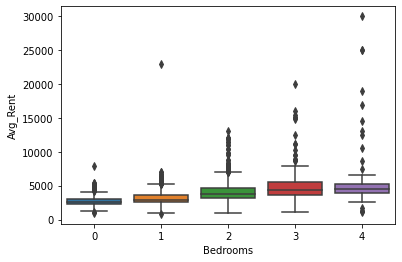

In [198]:
sns.boxplot(x = 'Bedrooms', y = 'Avg_Rent', data = df)

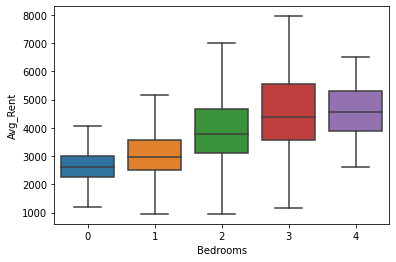

In [200]:
sns.boxplot(x = 'Bedrooms', y = 'Avg_Rent', data = df, showfliers = False)

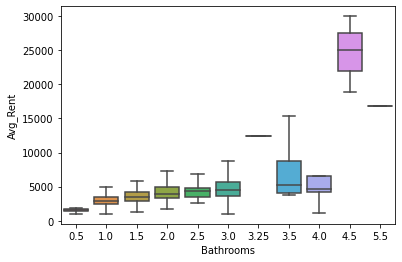

In [202]:
sns.boxplot(x = 'Bathrooms', y = 'Avg_Rent', data = df, showfliers = False)

In [205]:
df[df['Avg_Rent'] > 12500]

,Bedrooms,Bathrooms,City,Zip_Code,Neighborhood,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor,Zip_Code_Clean
1857,1,1.0,Oakland,94607,Uptown Oakland,23000,1620.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94607
2567,3,3.5,San Francisco,94105,Rincon,15148,2220.0,1,0,0,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,1,0,0,0,1,0,1,94105
2568,3,3.5,San Francisco,94105,Rincon,14836,2220.0,1,0,0,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,1,0,0,0,1,0,1,94105
2569,3,3.5,San Francisco,94105,Rincon,15408,2220.0,1,0,0,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,1,0,0,0,1,0,1,94105
2801,3,2.0,San Francisco,94103,Mission,16000,1518.0,0,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,94103
4607,4,3.5,San Francisco,94115,Lower Pacific Heights,14500,5113.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,94115
4752,3,3.5,San Francisco,94109,Russian Hill,15000,2330.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,94109
4753,3,3.0,San Francisco,94110,Baja Noe,20000,5351.0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,94110
4754,4,4.5,San Francisco,94121,Sea Cliff,30000,1899.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,San Francisco-other
4769,4,4.0,San Francisco,94114,Castro,13000,2658.0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,San Francisco-other
